# <center>CITS5508 Lab 2: Bean Classification</center>

**Name:** Chitra M Saraswati<br>
**Student ID:** 21367076<br>

In this workbook we use machine learning algorithms-specifically, classification algorithms-to classify beans to seven different varieties.

As per the data description:

"Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distinguish seven different registered varieties of dry beans with similar features in order to obtain uniform seed classification. For the classification model, images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. Bean images obtained by computer vision system were subjected to segmentation and feature extraction stages, and a total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains."

In [13]:
from pathlib import Path # vs os?
import os
from openpyxl import load_workbook

import numpy as np
import pandas as pd

np.random.seed(35)

%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
bean_path = os.path.join('DryBeanDataset', 'Dry_Bean_Dataset.xlsx')
os.path.exists(bean_path)

True

## 1. Import data; EDA

In [45]:
wb = load_workbook(bean_path)

from openpyxl.utils.dataframe import dataframe_to_rows
sheet = wb.active
data = sheet.values
cols = next(data)[0:]
df = pd.DataFrame(data, columns = cols)

In [43]:
df = pd.read_excel("./DryBeanDataset/Dry_Bean_Dataset.xlsx")

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [25]:
df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


### Exploratory Data Analysis

As per the data description, the following is the information for the attributes of this dataset:

1. Area (A): The area of a bean zone and the number of pixels within its boundaries.
2. Perimeter (P): Bean circumference is defined as the length of its border.
3. Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
4. Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
5. Aspect ratio (K): Defines the relationship between L and l.
6. Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
7. Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
8. Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
9. Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
10. Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
11. Roundness (R): Calculated with the following formula: ${(4\pi A)}/{(P^2)}$
12. Compactness (CO): Measures the roundness of an object: Ed/L
13. ShapeFactor1 (SF1)
14. ShapeFactor2 (SF2)
15. ShapeFactor3 (SF3)
16. ShapeFactor4 (SF4)
17. Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

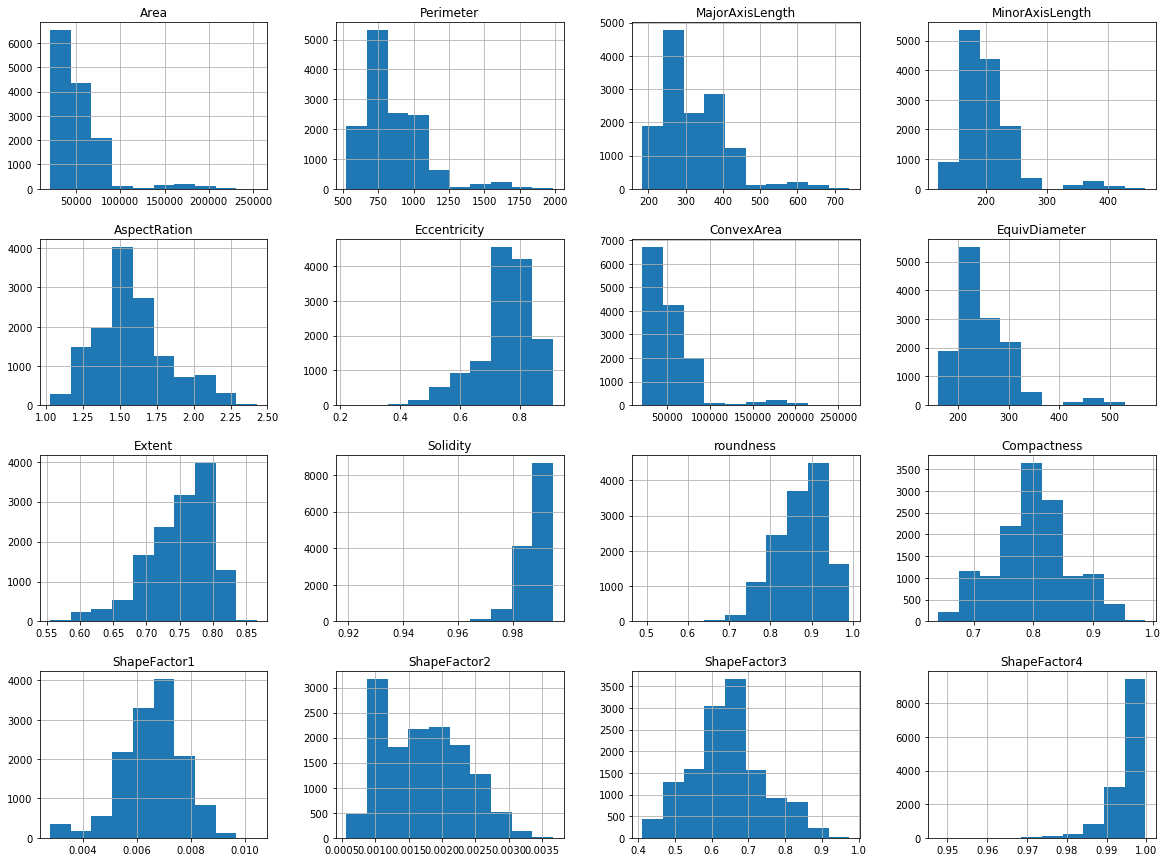

In [29]:
df.hist(figsize = (20,15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc150014b50>,
      dtype=object)

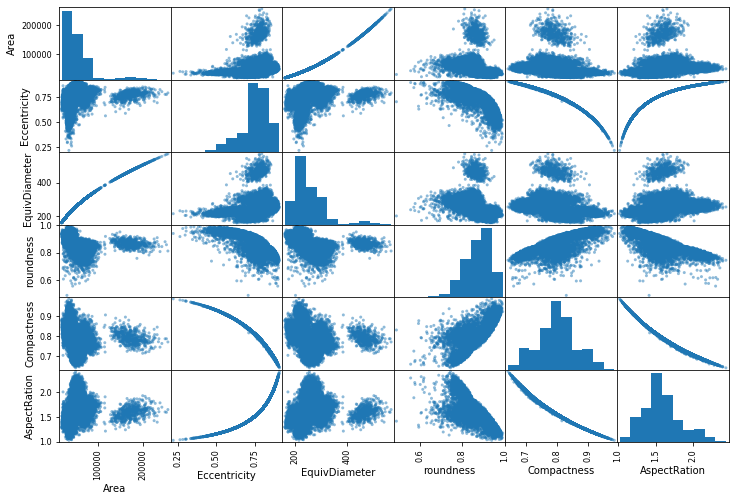

In [37]:
# Creating a scatter plot matrix for the six most interesting attributes:
# Area, eccentricity, equivalent diameter, roundness, compactness, and aspect ratio.

from pandas.plotting import scatter_matrix

bean_attr = ["Area", "Eccentricity", "EquivDiameter", 
             "roundness", "Compactness", "AspectRation"]
scatter_matrix(df[bean_attr], figsize = (12, 8))

The scatter plot matrix above indicates that we may be interested on classifying on equivalent diameter and area. These features are very different. 

But it's not a good idea to do the classification on the features which are pretty much perfectly correlated, such as:
* eccentricity vs compactness
* eccentricity vs aspect ratio
* area vs equivalent diameter
* compactness vs aspect ratio

## 2. Viewing class imbalances

In [32]:
df["Class"].value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

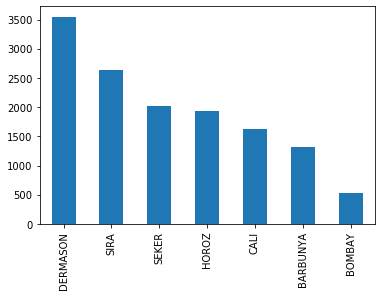

In [39]:
df["Class"].value_counts().plot(kind='bar')

We see that 

## 3. Split to training set and test set

In [4]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 35)

In [ ]:
len(train_set.index)

In [8]:
len(test_set.index)

2723

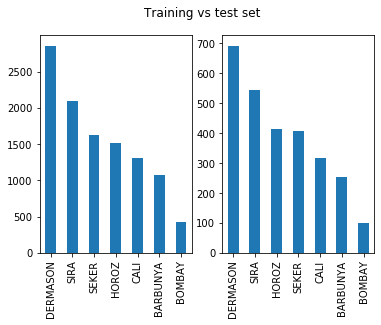

In [10]:
fig, (subpl1, subpl2) = plt.subplots(1, 2)
fig.suptitle("Training vs test set")

train_set["Class"].value_counts().plot(kind="bar", ax=subpl1)
test_set["Class"].value_counts().plot(kind="bar", ax=subpl2)

# 4. Feature scaling

We'll be using min-max scaling as we don't really have outliers (as per the histograms and scatter plots; refer to EDA in section one).

### Preparing the data for the ML algorithm

In [28]:
# Use only the training set
df = train_set
train_set.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
3817,203686,1722.932,660.997605,394.684760,1.674748,0.802163,206087,509.255407,0.790961,0.988350,0.862253,0.770435,0.003245,0.000705,0.593569,0.994079,BOMBAY
6141,50781,907.117,366.984978,178.103315,2.060517,0.874339,51606,254.276183,0.630483,0.984013,0.775505,0.692879,0.007227,0.001027,0.480081,0.989216,HOROZ
6090,50253,872.982,354.074847,181.355633,1.952379,0.858869,50859,252.950799,0.641604,0.988085,0.828631,0.714399,0.007046,0.001132,0.510366,0.996428,HOROZ
7130,60868,1018.898,416.225028,187.510757,2.219739,0.892775,61982,278.387400,0.760869,0.982027,0.736779,0.668839,0.006838,0.000844,0.447345,0.992990,HOROZ
6625,55106,927.101,371.976078,190.338253,1.954290,0.859167,55705,264.883254,0.776360,0.989247,0.805665,0.712098,0.006750,0.001071,0.507083,0.990987,HOROZ


In [29]:
# Check for any NA values
sample_incomplete_rows = df[df.isnull().any(axis=1)].head()
sample_incomplete_rows

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class


In [21]:
# Select numeric variables only
df_num = df.select_dtypes(include=[np.number])

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRation',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Solidity',
 'roundness',
 'Compactness',
 'ShapeFactor1',
 'ShapeFactor2',
 'ShapeFactor3',
 'ShapeFactor4']

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

num_pipeline = Pipeline([
        ('std_scaler', MinMaxScaler())
    ])

df_num_tr = num_pipeline.fit_transform(df_num)
df_num_tr
#QN why does it work here but not below (without pipeline)?
#QN fit, fit_transform and transform function?

array([[0.78253258, 0.82032597, 0.85977256, ..., 0.04550786, 0.32463071,
        0.89178084],
       [0.12963928, 0.26179111, 0.33026717, ..., 0.14940349, 0.12356341,
        0.79829134],
       [0.12738475, 0.23842112, 0.30701652, ..., 0.18314935, 0.17721938,
        0.93693095],
       ...,
       [0.11086013, 0.20256272, 0.22139572, ..., 0.33739788, 0.38653996,
        0.83707605],
       [0.08775983, 0.17713609, 0.15199351, ..., 0.504547  , 0.55988531,
        0.97418321],
       [0.1138747 , 0.21871187, 0.28868212, ..., 0.19145305, 0.17119569,
        0.80617175]])

In [41]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

df_num_tr = minmax.fit_transform(df_num)
df_num_tr

array([[0.78253258, 0.82032597, 0.85977256, ..., 0.04550786, 0.32463071,
        0.89178084],
       [0.12963928, 0.26179111, 0.33026717, ..., 0.14940349, 0.12356341,
        0.79829134],
       [0.12738475, 0.23842112, 0.30701652, ..., 0.18314935, 0.17721938,
        0.93693095],
       ...,
       [0.11086013, 0.20256272, 0.22139572, ..., 0.33739788, 0.38653996,
        0.83707605],
       [0.08775983, 0.17713609, 0.15199351, ..., 0.504547  , 0.55988531,
        0.97418321],
       [0.1138747 , 0.21871187, 0.28868212, ..., 0.19145305, 0.17119569,
        0.80617175]])

In [31]:
df_num_tr.shape

(10888, 16)

In [37]:
pdf_num_tr = pd.DataFrame(df_num_tr)
pdf_num_tr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.782533,0.820326,0.859773,0.801744,0.462404,0.842218,0.764306,0.852697,0.757999,0.916110,0.704018,0.374526,0.066303,0.045508,0.324631,0.891781
1,0.129639,0.261791,0.330267,0.146331,0.736887,0.946448,0.127473,0.227948,0.241792,0.858626,0.504100,0.150846,0.631397,0.149403,0.123563,0.798291
2,0.127385,0.238421,0.307017,0.156173,0.659944,0.924106,0.124393,0.224700,0.277565,0.912599,0.626534,0.212913,0.605713,0.183149,0.177219,0.936931
3,0.172710,0.338320,0.418947,0.174800,0.850177,0.973070,0.170247,0.287025,0.661202,0.832292,0.414855,0.081511,0.576237,0.090284,0.065565,0.870836
4,0.148107,0.275473,0.339256,0.183356,0.661304,0.924537,0.144371,0.253937,0.711030,0.928006,0.573607,0.206275,0.563752,0.163344,0.171402,0.832335


# 5. Using the Support Vector Classifier

## 5.1 Train the model

In [49]:
from sklearn.svm import SVC

## 5.2 Cross-validate

## 6. Using the Stochastic Gradient Descent Classifier

## 6.1 Train the model

In [40]:
y_train_sira = (train_set["Class"] == "SIRA")
y_train_sira

3817    False
6141    False
6090    False
7130    False
6625    False
        ...  
3007    False
7148    False
9143     True
1295    False
5833    False
Name: Class, Length: 10888, dtype: bool

In [47]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 35)
sgd_clf.fit(df_num_tr, y_train_sira)

SGDClassifier(random_state=35)

In [48]:
sgd_clf.predict()

ValueError: Expected 2D array, got 1D array instead:
array=[1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## 6.2 Cross-validate

## 7. Comparing the two classifiers